In [1]:
from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dprasannavenkatesh","key":"09a552d9b412718c3ecdece5322d84b4"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle


In [4]:
!kaggle datasets download dprasannavenkatesh/kidney

Dataset URL: https://www.kaggle.com/datasets/dprasannavenkatesh/kidney
License(s): unknown
 97% 1.76G/1.82G [00:11<00:01, 39.5MB/s]
100% 1.82G/1.82G [00:11<00:00, 169MB/s] 


In [5]:
!unzip kidney.zip

Streaming output truncated to the last 5000 lines.
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1199).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (12).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (120).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1200).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1201).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1202).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1203).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1204).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1205).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1206).jpg  
  inflating: kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumo

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout,
    GlobalAveragePooling2D, Activation, Add, GaussianNoise, Reshape,
    SpatialDropout2D, LeakyReLU, ReLU, Lambda, Input
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import cv2

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
base_dir = r'/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

In [8]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']

In [ ]:
data = []
valid_extensions = ('.jpg') 

for label in classes:
    folder_path = os.path.join(base_dir, label)

   
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.lower().endswith(valid_extensions):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))

In [10]:
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [11]:
df.head()

,file_path,label
0,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst
1,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst
2,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst
3,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst
4,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst


In [12]:
df.shape

(21863, 2)

In [13]:
df['label'].value_counts()

,count
label,
Normal,7239
Cyst,6648
Tumor,5222
Stone,2754


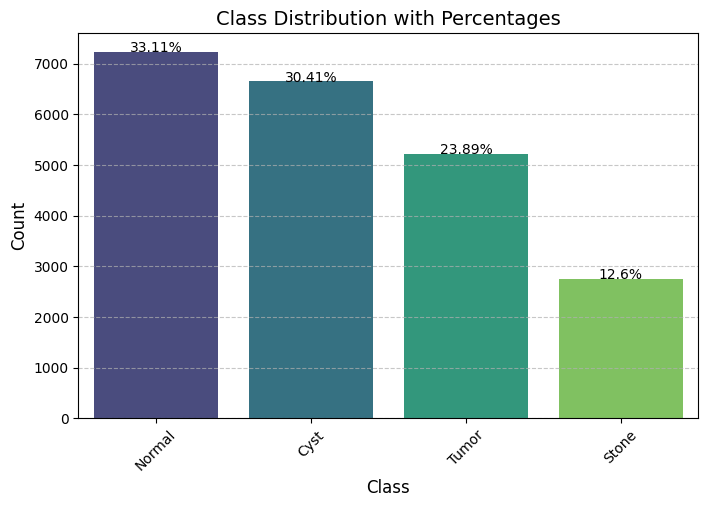

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
value_counts = value_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(8, 5))

ax = sns.barplot(data=value_counts, x='label', y='count', palette="viridis")

for i, row in value_counts.iterrows():
    ax.text(i, row['count'] + 2, f"{row['percentage']}%", ha='center', fontsize=10, color='black')

plt.title("Class Distribution with Percentages", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

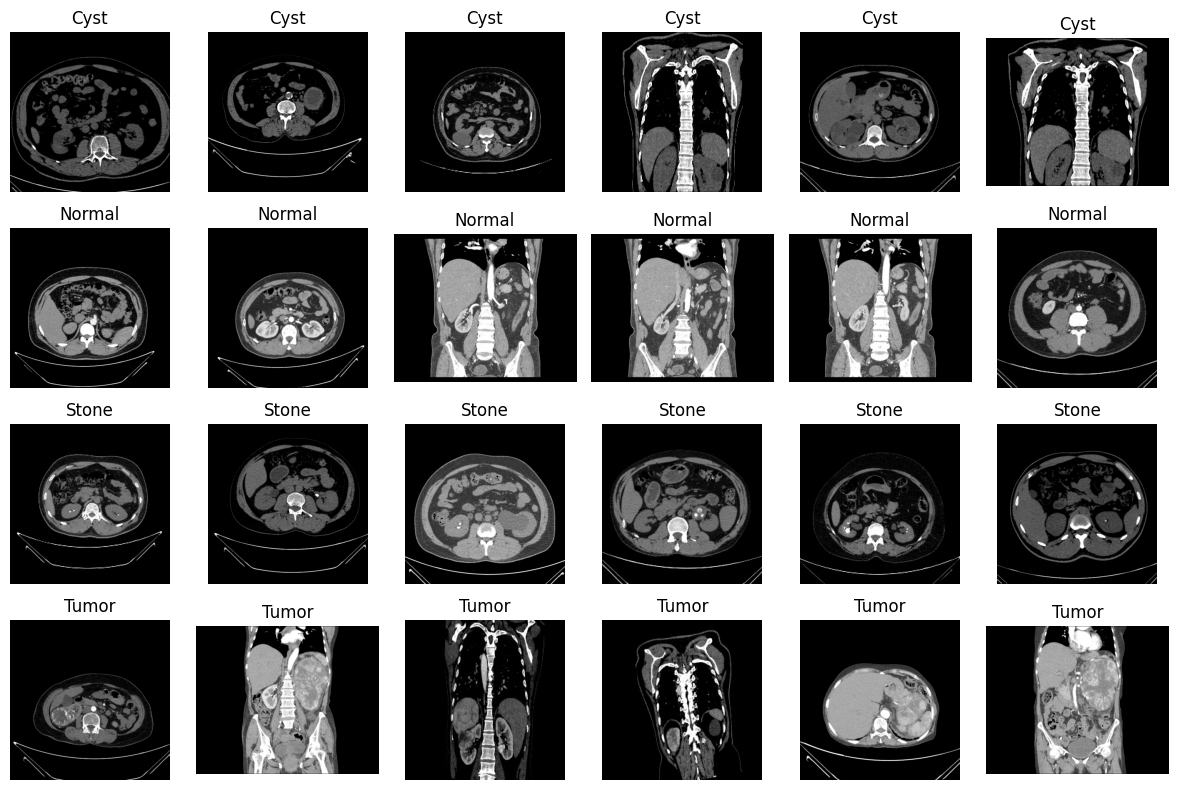

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']


fig, axes = plt.subplots(4, 6, figsize=(12, 8))  
axes = axes.flatten()


for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 6)

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 6 + j].imshow(img)  
        axes[i * 6 + j].axis('off')  
        axes[i * 6 + j].set_title(label)  

plt.tight_layout()
plt.show()

In [ ]:

label_mapping = {'Normal': 1, 'Cyst': 0, 'Stone': 2, 'Tumor': 3}


df['numeric_label'] = df['label'].map(label_mapping)


print(df[['label', 'numeric_label']])

        label  numeric_label
0        Cyst              0
1        Cyst              0
2        Cyst              0
3        Cyst              0
4        Cyst              0
...       ...            ...
21858  Normal              1
21859  Normal              1
21860  Normal              1
21861  Normal              1
21862  Normal              1

[21863 rows x 2 columns]


In [17]:
df.head()

,file_path,label,numeric_label
0,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst,0
1,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst,0
2,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst,0
3,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst,0
4,/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...,Cyst,0


In [ ]:
import os
import pandas as pd
from pathlib import Path

train_dir = Path("/content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")



normal_cases_dir = train_dir / 'Normal'
cyst_cases_dir = train_dir / 'Cyst'
stone_cases_dir = train_dir / 'Stone'
tumor_cases_dir = train_dir / 'Tumor'


normal_cases = list(normal_cases_dir.glob('*.jpg'))
cyst_cases = list(cyst_cases_dir.glob('*.jpg'))
stone_cases = list(stone_cases_dir.glob('*.jpg'))
tumor_cases = list(tumor_cases_dir.glob('*.jpg'))


train_data = []

for img in cyst_cases:
    train_data.append((str(img), 1))  
for img in normal_cases:
    train_data.append((str(img), 0)) 
for img in stone_cases:
    train_data.append((str(img), 3))  
for img in tumor_cases:
    train_data.append((str(img), 2))  


train_data = pd.DataFrame(train_data, columns=['image', 'label'])


train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)


print(train_data.head())

                                               image  label
0  /content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...      0
1  /content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...      0
2  /content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...      2
3  /content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...      2
4  /content/kidney/CT-KIDNEY-DATASET-Normal-Cyst-...      2


 Befor Oversampling:
label
0    7239
1    6648
2    5222
3    2754
Name: count, dtype: int64


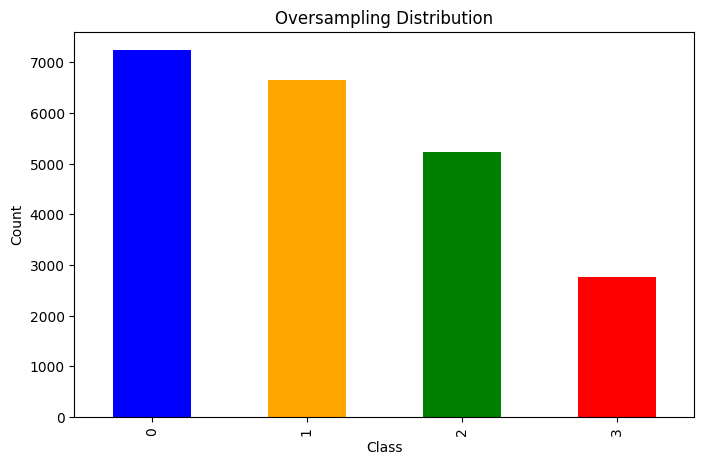

In [ ]:
import matplotlib.pyplot as plt


class_counts = train_data['label'].value_counts()
print(" Befor Oversampling:")
print(class_counts)

plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Oversampling Distribution")
plt.show()

After Oversampling:
label
2    7239
3    7239
0    7239
1    7239
Name: count, dtype: int64


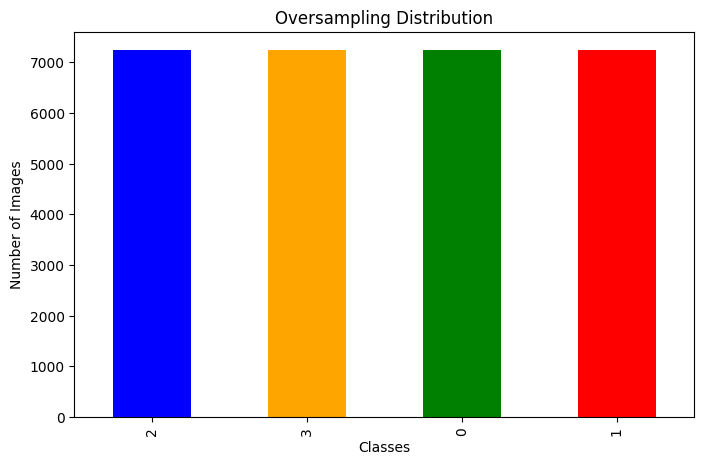

In [ ]:
from sklearn.utils import resample
import matplotlib.pyplot as plt


max_count = class_counts.max()

balanced_data = []


for label, count in class_counts.items():
    subset = train_data[train_data['label'] == label]
    if count < max_count:
        subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_data.append(subset)


train_data_balanced = pd.concat(balanced_data)

train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


print("After Oversampling:")
print(train_data_balanced['label'].value_counts())


plt.figure(figsize=(8,5))
train_data_balanced['label'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Oversampling Distribution")
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd


train_data_balanced = train_data.copy()


oversampler = RandomOverSampler(random_state=42)


X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])


train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})


print(train_data_balanced['label'].value_counts())

label
0    7239
2    7239
1    7239
3    7239
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)


print("Training Set Distribution:\n", train_data['label'].value_counts())
print("Test Set Distribution:\n", test_data['label'].value_counts())

Training Set Distribution:
 label
0    5791
1    5318
2    4178
3    2203
Name: count, dtype: int64
Test Set Distribution:
 label
0    1448
1    1330
2    1044
3     551
Name: count, dtype: int64


In [23]:
train_data['label'] = train_data['label'].astype(str)

In [24]:
test_data['label'] = test_data['label'].astype(str)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd


train_data_balanced = train_data.copy()


oversampler = RandomOverSampler(random_state=42)


X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])


train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})


print(train_data_balanced['label'].value_counts())

label
2    5791
3    5791
0    5791
1    5791
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1/255,           
    rotation_range=10,       
    width_shift_range=0.12,  
    height_shift_range=0.12, 
    shear_range=0.2,        
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest'      
)


test_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_balanced,
    x_col='image',         
    y_col='label',          
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical', 
    shuffle=True,            
    color_mode='grayscale'   
)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',          
    y_col='label',          
    target_size=(224, 224),  
    batch_size=32,         
    class_mode='categorical', 
    shuffle=False,          
    color_mode='grayscale'  
)

Found 23164 validated image filenames belonging to 4 classes.
Found 4373 validated image filenames belonging to 4 classes.


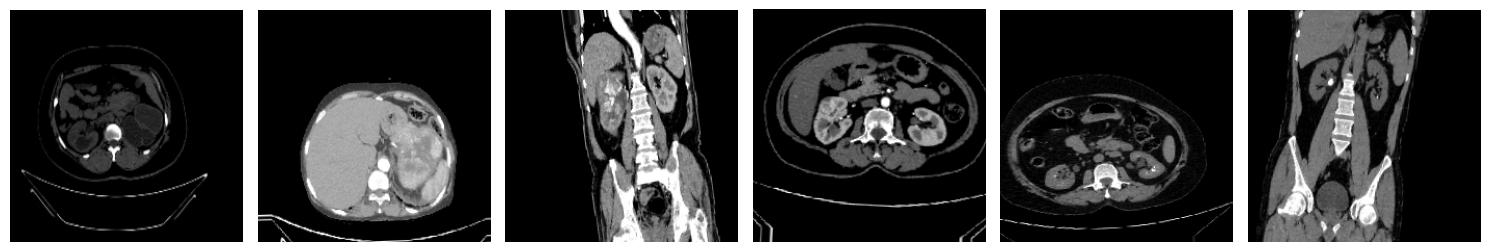

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


num_images = 6


augmented_images, _ = next(train_generator)

num_images = min(num_images, augmented_images.shape[0])


fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img = augmented_images[i]
    img = np.clip(img, 0, 1) 
   
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


model = Sequential()


model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1))) 
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(256, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(GlobalMaxPooling2D())


model.add(Dense(256))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(Dense(128))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))


model.add(Dense(4, activation='softmax'))


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


checkpoint = ModelCheckpoint('./kidneymodel.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 488,964 (1.87 MB)

 Trainable params: 488,004 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
import tensorflow as tf

Epochs = 100

class UserPromptCallback(tf.keras.callbacks.Callback):
    def __init__(self, prompt_frequency, max_epochs=Epochs):
        super(UserPromptCallback, self).__init__()
        self.prompt_frequency = prompt_frequency
        self.max_epochs = max_epochs
        self.remaining_epochs = prompt_frequency

    def on_epoch_end(self, epoch, logs=None):
        
        if epoch + 1 >= self.max_epochs:
            print(f"Reached maximum epoch {self.max_epochs}. Stopping training.")
            self.model.stop_training = True
            return

        
        self.remaining_epochs -= 1
        if self.remaining_epochs <= 0:
            response = input(f"Epoch {epoch + 1} completed. Do you want to stop training or add more epochs? (stop/add): ").strip().lower()
            if response == 'stop':
                print("Stopping training as requested by the user.")
                self.model.stop_training = True
            elif response == 'add':
                try:
                    additional_epochs = int(input("How many more epochs to add? ").strip())
                    print(f"Added {additional_epochs} more epochs.")
                    self.max_epochs += additional_epochs  
                    self.remaining_epochs = additional_epochs
                except ValueError:
                    print("Invalid input. Continuing training.")


user_prompt_callback = UserPromptCallback(prompt_frequency=20)

history = model.fit(
    train_generator,
    epochs=Epochs,
    callbacks=[checkpoint,early_stopping,reduce_lr, user_prompt_callback],
    validation_data=test_generator
)
model.save('kidneymodel.keras')


test_generator.reset()


test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Epoch 1/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5751 - loss: 1.0667
Epoch 1: val_loss improved from inf to 0.61157, saving model to ./kidneymodel.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 184s 238ms/step - accuracy: 0.5752 - loss: 1.0663 - val_accuracy: 0.7267 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8787 - loss: 0.3230
Epoch 2: val_loss improved from 0.61157 to 0.27347, saving model to ./kidneymodel.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 159s 219ms/step - accuracy: 0.8788 - loss: 0.3230 - val_accuracy: 0.9074 - val_loss: 0.2735 - learning_rate: 1.0000e-04
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9394 - loss: 0.1701
Epoch 3: val_loss improved from 0.27347 to 0.17768, saving model to ./kidneymodel.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 164s 227ms/step - accuracy: 0.9394 - loss: 0.1701 - val_accuracy: 0.9403 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 4/100
724/724 ━━━━━━

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()


diseases_labels = {1: 'Cyst', 0: 'Normal', 3: 'Stone', 2: 'Tumor'}

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(224, 224), color_mode='grayscale') 
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_class_index = np.argmax(classes)
  predicted_class_label = diseases_labels[predicted_class_index]

  print(fn)
  print(f"Predicted class: {predicted_class_label}")

Saving Cyst- (141).jpg to Cyst- (141).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Cyst- (141).jpg
Predicted class: Cyst
